# CNN modeling

In [5]:
import pandas as pd
# import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(42)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [7]:
learning_rate = 0.001
EPOCHS = 15
BATCH_SIZE = 32

In [8]:
train_dataset = dsets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())

test_dataset = dsets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29804153.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [2]:
# 학습 진행 코드
def train(train_loader, model, criterion, optimizer):
  for epoch in range(EPOCHS):
      avg_cost = 0

      for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
          X = X.to(device)
          Y = Y.to(device)

          optimizer.zero_grad()
          output = model(X)
          cost = criterion(output, Y)
          cost.backward()
          optimizer.step()

          avg_cost += cost / len(train_loader)

      print('[Epoch: {:>4}] Loss = {:>.9}'.format(epoch + 1, avg_cost))

In [3]:
# 모델 평가
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## CNN

In [ ]:
# input : (1,32,32,3) 배치크기*높이*너비*채널
class CNN2d(nn.Module):
    def __init__(self, channels):
        super(CNN2d, self).__init__()
        # (3, 32, 32)
        self.conv = nn.Sequential(
            # conv layer 1
            nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            # (32, 32, 32) --> kernel, stride, padding size로 인해 28x28유지
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (32, 16, 16)

            # conv layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # (64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (64, 8, 8)

            # conv layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            # (128, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # (128, 4, 4)
        )
        # Feature_map = batch_size*4*4*128
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024, bias=True),
            nn.ReLU(),

            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),

            nn.Linear(512, 10, bias=True)
        )
    def forward(self, x):
        x = self.conv(x)
        # fclayer을 위한 평탄화
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# channles --> 컬러
CNN_Model = CNN2d(3).to(device)
# cross_entropy 손실함수 안에는 log_softmax 연산을 수행하고 있어 모델링 할 필요가 없다.
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(CNN_Model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(EPOCHS):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        output = CNN_Model(X)
        cost = criterion(output, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / len(train_loader)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.49155092
[Epoch:    2] cost = 1.0414114
[Epoch:    3] cost = 0.849004984
[Epoch:    4] cost = 0.728935361
[Epoch:    5] cost = 0.623940587
[Epoch:    6] cost = 0.527303278
[Epoch:    7] cost = 0.440879613
[Epoch:    8] cost = 0.361166209
[Epoch:    9] cost = 0.291622609
[Epoch:   10] cost = 0.240863174
[Epoch:   11] cost = 0.202435896
[Epoch:   12] cost = 0.176215157
[Epoch:   13] cost = 0.161753714
[Epoch:   14] cost = 0.140500337
[Epoch:   15] cost = 0.132252201


In [ ]:
_, test_accuracy = evaluate(CNN_Model,test_loader)
test_accuracy

71.6

## AlexNet
* data augmentation
* 병렬구조
* 5개 conv 레이어, 3개 pooling(max), 3개 FC 레이어
* dropout
* LRN(local response normalization) 2개

In [20]:
train_data = dsets.CIFAR10(root="./data/",
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

Files already downloaded and verified


In [21]:
train_transform = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,std=stds)
                        ])

test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

# CIFAR-10 데이터셋 로드, augmentation을 적용
train_dataset_alex = dsets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=train_transform)

test_dataset_alex = dsets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=test_transform)

train_loader_alex = torch.utils.data.DataLoader(dataset=train_dataset_alex,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           shuffle=True)

test_loader_alex = torch.utils.data.DataLoader(dataset=test_dataset_alex,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# input : (32,32,3) 배치크기*높이*너비*채널
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),

        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192),

        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace=True)
    )

    self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, 10)
    )
  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

# class AlexNet(nn.Module):
#     def __init__(self):
#         super(AlexNet, self).__init__()
#         self.conv = nn.Sequential(
#             # 64,64,3
#             nn.Conv2d(3, 64, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             # 33,33,64
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # 16,16,64
#             nn.Conv2d(64, 192, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(192),
#             # 16,16,192
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # 7,7,192
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             # 7,7,384
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),

#             # 7,7,256
#             nn.Conv2d(256, 256, kernel_size=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256 * 3 * 3, 1024),
#             nn.ReLU(inplace=True),

#             nn.Dropout(0.5),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),

#             nn.Linear(512, 10)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(-1, 256*3*3)
#         x = self.fc(x)
#         return x

In [23]:
AlexNet_model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(AlexNet_model.parameters(), lr=learning_rate)

In [24]:
train(train_loader_alex, AlexNet_model, criterion, optimizer)

[Epoch:    1] Loss = 1.68048632
[Epoch:    2] Loss = 1.30644429
[Epoch:    3] Loss = 1.13361526
[Epoch:    4] Loss = 1.0381453
[Epoch:    5] Loss = 0.967074573
[Epoch:    6] Loss = 0.918014824
[Epoch:    7] Loss = 0.87241143
[Epoch:    8] Loss = 0.844315231
[Epoch:    9] Loss = 0.818878174
[Epoch:   10] Loss = 0.795273244
[Epoch:   11] Loss = 0.77336812
[Epoch:   12] Loss = 0.755077422
[Epoch:   13] Loss = 0.727212965
[Epoch:   14] Loss = 0.716697335
[Epoch:   15] Loss = 0.703699112


In [25]:
_, test_accuracy = evaluate(AlexNet_model,test_loader_alex)
test_accuracy

76.91

## VGGNet

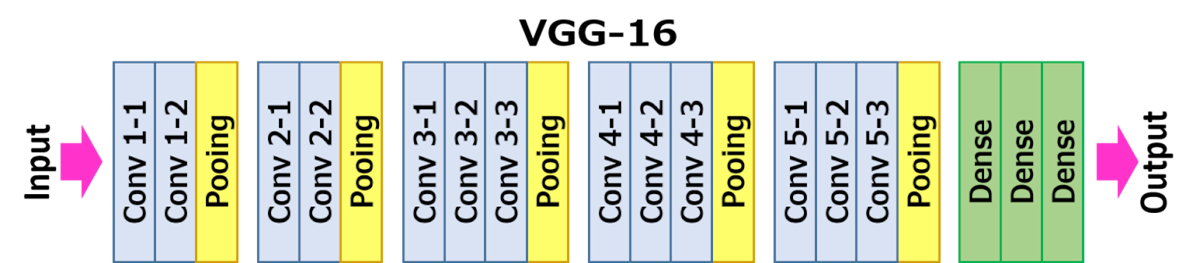

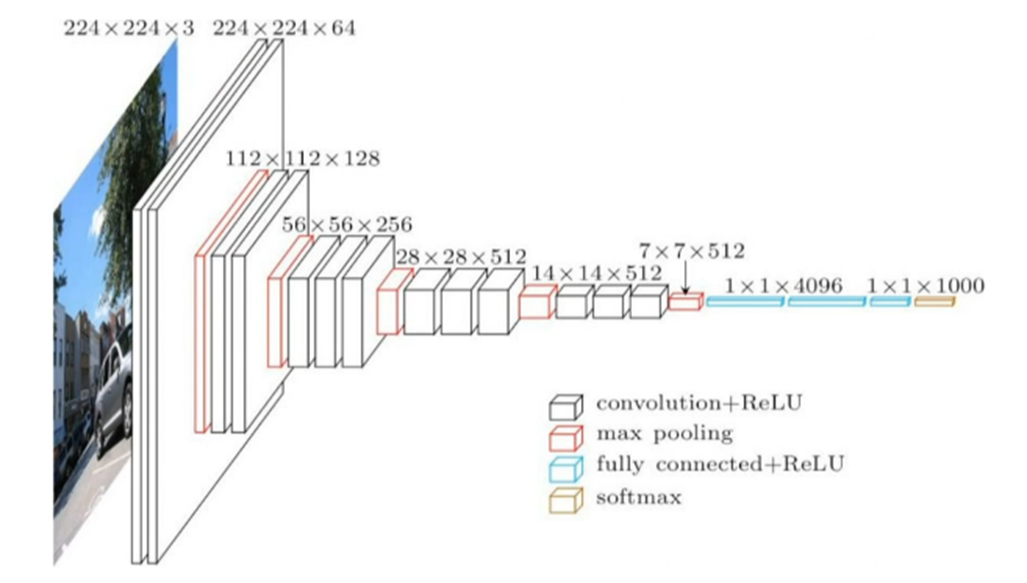

In [34]:
transform_vgg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_vgg = dsets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transform_vgg)

test_dataset_vgg = dsets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transform_vgg)

train_loader_vgg = torch.utils.data.DataLoader(dataset=train_dataset_vgg,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader_vgg = torch.utils.data.DataLoader(dataset=test_dataset_vgg,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
class VGG16Net(nn.Module):
  def __init__(self):
    super(VGG16Net, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
        nn.Linear(512, 512),
        nn.Linear(512, 512),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

# class VGG16Net(nn.Module):
#   def __init__(self):
#     super(VGG16Net, self).__init__()
#     self.conv = nn.Sequential(
#         nn.Conv2d(3, 64, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(64, 64, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Conv2d(64, 128, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(128, 128, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Conv2d(128,256,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(256,256,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(256,256,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Conv2d(256,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(512,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(512,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Conv2d(512,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(512,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(512,512,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2)
#     )

#     self.fc = nn.Sequential(
#         nn.Linear(8*64*1*1, 4096),
#         nn.ReLU(True),
#         nn.Dropout(),
#         nn.Linear(4096, 1000),
#         nn.ReLU(True),
#         nn.Dropout(),
#         nn.Linear(1000, 10),
#     )
#   def forward(self, x):
#     x = self.conv(x)
#     x = x.view(x.size(0), -1)
#     x = self.fc(x)
#     return x

In [39]:
VGG16_model = VGG16Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16_model.parameters(), lr=learning_rate)

In [40]:
train(train_loader_vgg, VGG16_model, criterion, optimizer)

[Epoch:    1] Loss = 1.9827354
[Epoch:    2] Loss = 1.85132372
[Epoch:    3] Loss = 1.6528759
[Epoch:    4] Loss = 1.48959005
[Epoch:    5] Loss = 1.36182034
[Epoch:    6] Loss = 1.22036445
[Epoch:    7] Loss = 1.13201237
[Epoch:    8] Loss = 1.06630278
[Epoch:    9] Loss = 1.03641188
[Epoch:   10] Loss = 1.01885509
[Epoch:   11] Loss = 0.953517914
[Epoch:   12] Loss = 0.942690909
[Epoch:   13] Loss = 0.922082305
[Epoch:   14] Loss = 0.911655247
[Epoch:   15] Loss = 0.87751925


In [41]:
_, test_accuracy = evaluate(VGG16_model,test_loader_vgg)
test_accuracy

68.57

## GoogLeNet
* **인셉션** 모듈이라는 방식을 사용해서 모델 성능 개선
  * 일반 CNN 모델은 층마다 ConvNet을 한 번만 수행하여 합성곱 kernel의 크기와 pooling 레이어의 위치가 모델의 성능을 구분하는 핵심 요소
  * 이전 층에서 입력되는 값에 대해서 합성곱 필터와 풀링 필터를 포함해서 여러개의 필터를 한번에 적용

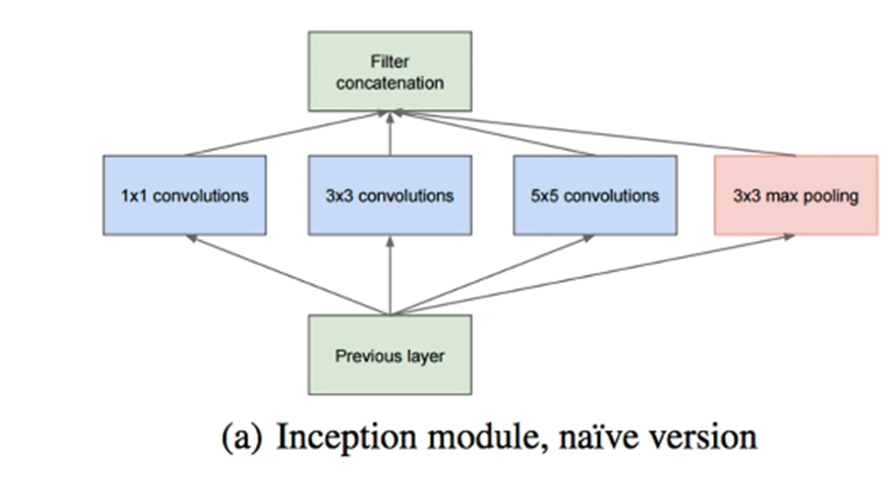

여러 개의 필터를 한번에 적용할 경우 파라미터의 수가 증가하는데  
inceiption Net은 이 문제를 해결하기 위해서 중간에 1x1 필터를 추가하여 차원을 감소시킨다.

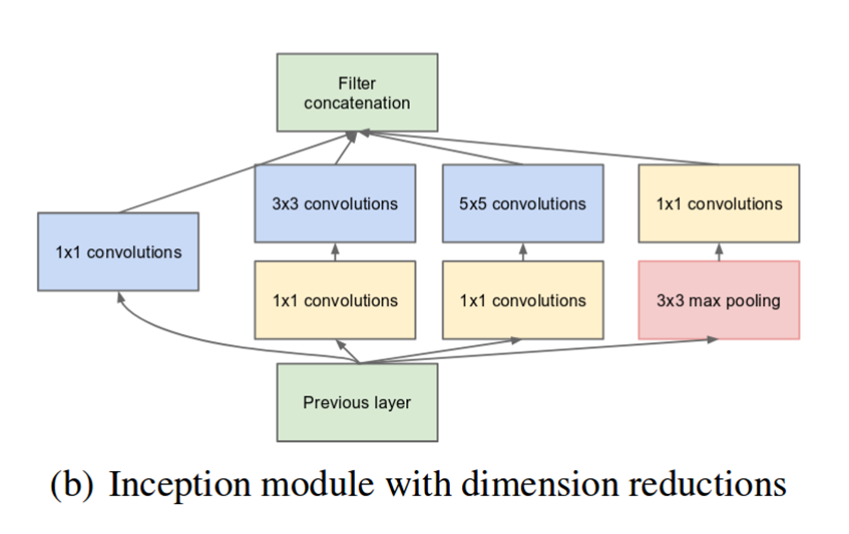

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5088964127604166, 0.48739301317401956, 0.44194221124387256), (0.2682515741720801, 0.2573637364478126, 0.2770957707973042))
])

train_dataset_google = dsets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transform_train)

test_dataset_google = dsets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transform_test)

train_loader_google = torch.utils.data.DataLoader(dataset=train_dataset_google,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader_google = torch.utils.data.DataLoader(dataset=test_dataset_google,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
class Inception(nn.Module):
  def __init__(self, in_channels, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pooling):
    super(Inception, self).__init__()
    # 1x1 convolutions
    self.b1 = nn.Sequential(
        nn.Conv2d(in_channels, kernel_1_x, kernel_size=1),
        nn.BatchNorm2d(kernel_1_x),
        nn.ReLU(True)
    )

    # 1x1 conv -> 3x3 conv branch
    self.b2 = nn.Sequential(
        nn.Conv2d(in_channels, kernel_3_in, kernel_size=1),
        nn.BatchNorm2d(kernel_3_in),
        nn.ReLU(True),
        nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
        nn.BatchNorm2d(kernel_3_x),
        nn.ReLU(True),
    )

    # 1x1 conv -> 5x5 conv branch
    self.b3 = nn.Sequential(
        nn.Conv2d(in_channels, kernel_5_in, kernel_size=1),
        nn.BatchNorm2d(kernel_5_in),
        nn.ReLU(True),
        nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
        nn.BatchNorm2d(kernel_5_x),
        nn.ReLU(True),
        nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
        nn.BatchNorm2d(kernel_5_x),
        nn.ReLU(True),
    )

    # 3x3 pool -> 1x1 conv branch
    self.b4 = nn.Sequential(
        nn.MaxPool2d(3, stride=1, padding=1),
        nn.Conv2d(in_channels, pooling, kernel_size=1),
        nn.BatchNorm2d(pooling),
        nn.ReLU(True),
    )

  def forward(self, x):
      # Concatenate the outputs of all branches
      return torch.cat([self.b1(x),self.b2(x),self.b3(x),self.b4(x)], 1)

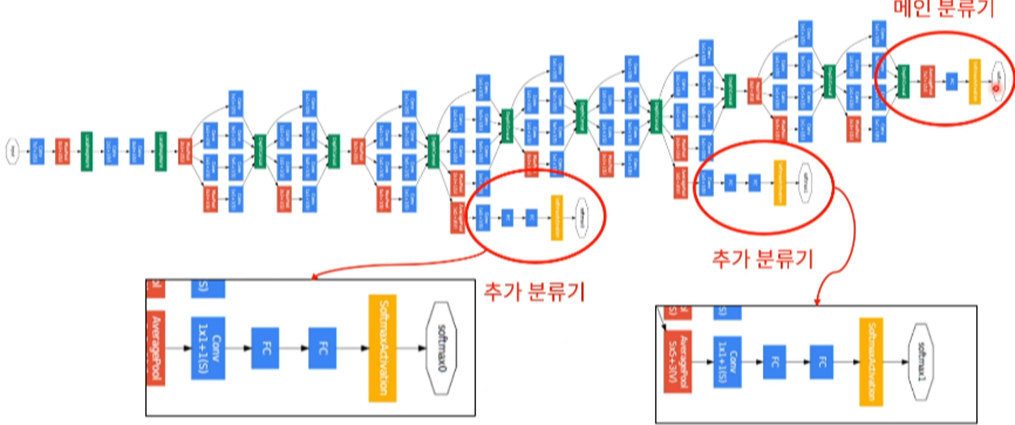

In [13]:
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.avg_pool(x)
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=7, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 192, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.inception_a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.inception_b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        # Auxiliary classifier 1
        self.aux1 = AuxiliaryClassifier(512)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception_a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.inception_b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.inception_c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.inception_d4 = Inception(512, 112, 144, 288, 32,  64,  64)

        # Auxiliary classifier 2
        self.aux2 = AuxiliaryClassifier(528)
        self.inception_e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.inception_a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.max_pool(x)

        x = self.inception_a3(x)
        x = self.inception_b3(x)
        x = self.max_pool(x)

        x = self.inception_a4(x)

        aux1 = self.aux1(x)

        x = self.inception_b4(x)
        x = self.inception_c4(x)
        x = self.inception_d4(x)

        aux2 = self.aux2(x)

        x = self.inception_e4(x)
        x = self.max_pool(x)

        x = self.inception_a5(x)
        x = self.inception_b5(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, aux1, aux2

In [19]:
GoogLeNet_model = GoogLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(GoogLeNet_model.parameters(), lr=learning_rate)

In [20]:
# 학습 진행 코드
def train_aux(train_loader, model, criterion, optimizer):
  for epoch in range(EPOCHS):
      avg_loss = 0

      for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
          X = X.to(device)
          Y = Y.to(device)

          optimizer.zero_grad()
          output, aux1, aux2 = model(X)
          loss = criterion(output, Y) + 0.3 * criterion(aux1, Y) + 0.3 * criterion(aux2, Y)
          loss.backward()
          optimizer.step()

          avg_loss += loss / len(train_loader)

      print('[Epoch: {:>4}] Loss = {:>.9}'.format(epoch + 1, avg_loss))

In [21]:
train_aux(train_loader_google, GoogLeNet_model, criterion, optimizer)

[Epoch:    1] Loss = 2.86058664
[Epoch:    2] Loss = 2.39279509
[Epoch:    3] Loss = 2.11703467
[Epoch:    4] Loss = 1.89491415
[Epoch:    5] Loss = 1.7166307
[Epoch:    6] Loss = 1.5994736
[Epoch:    7] Loss = 1.48521757
[Epoch:    8] Loss = 1.37781119
[Epoch:    9] Loss = 1.29734564
[Epoch:   10] Loss = 1.24618793
[Epoch:   11] Loss = 1.30101943
[Epoch:   12] Loss = 1.15584993
[Epoch:   13] Loss = 1.10120976
[Epoch:   14] Loss = 1.09589791
[Epoch:   15] Loss = 1.0674665


In [22]:
# 모델 평가
def evaluate_aux(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output, _, _ = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [23]:
_, test_accuracy = evaluate_aux(GoogLeNet_model,test_loader_google)
test_accuracy

65.12

## ResNet
* 레이어가 34개로 깊어지며 과적합이 발생할 것으로 보이지만
* 해당 논문에선 파라미터 증가로 과적합이 발생하는 것은 특정 시점까지고, 그 이후부턴 성능이 일정하게 유지된다는 것을 밝혔다.
* 따라서 과적합의 주 원인이 층의 갯수가 아니었고 **경사소실**로 파라미터 업데이트가 이뤄지지 않은 것이었다.
* 이를 해결하기 위해 **Skip Connection** 구조가 등장한다.  

**핵심 아이디어**   
* 입력값을 이용해서 출력값을 완전히 새로 계산하는 것이 아니라, 입력값(`x`)과 원래 출력하고자 하는 값(`H(x)`)의 차이(residual) : `H(x)-x` 만을 새롭게 학습
* 이럴 경우 역전파시 미분을 할 때 `x`의 1이 남아 있게 되어 경사 소실 문제가 해결된다.

기존 모델은 최적의 `H(x)`를 찾지만  
ResNet은 잔차 `F(x)`를 감소시키는 방향으로 학습

In [30]:
class BasicBlock(nn.Module):
	# mul은 추후 ResNet18, 34, 50, 101, 152등 구조 생성에 사용됨
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()

        # stride를 통해 너비와 높이 조정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        # stride=1, padding=1 => 너비와 높이는 항시 유지
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        # x를 그대로 더해주기 위함
        self.shortcut = nn.Sequential()
        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # 필요에 따라 layer를 Skip
        out = F.relu(out)
        return out

In [31]:
class ResNet(nn.Module):
	# CIFAR-10을 학습시킬 것이므로, num_classes=10으로 설정
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # Basic Resiudal Block일 경우 그대로, BottleNeck일 경우 4를 곱한다.
        self.linear = nn.Linear(512 * block.mul, num_classes)

    # 다양한 Architecture 생성을 위해 make_layer로 Sequential 생성
    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [32]:
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [33]:
ResNet_model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet_model.parameters(), lr=learning_rate)

In [34]:
train(train_loader_google, ResNet_model, criterion, optimizer)

[Epoch:    1] Loss = 1.53649294
[Epoch:    2] Loss = 1.11987662
[Epoch:    3] Loss = 0.946620166
[Epoch:    4] Loss = 0.816742182
[Epoch:    5] Loss = 0.754868388
[Epoch:    6] Loss = 0.692895889
[Epoch:    7] Loss = 0.616775215
[Epoch:    8] Loss = 0.573089242
[Epoch:    9] Loss = 0.521072924
[Epoch:   10] Loss = 0.462419838
[Epoch:   11] Loss = 0.445543349
[Epoch:   12] Loss = 0.400899947
[Epoch:   13] Loss = 0.355813861
[Epoch:   14] Loss = 0.382052481
[Epoch:   15] Loss = 0.299176365


In [35]:
_, test_accuracy = evaluate(ResNet_model,test_loader_google)
test_accuracy

69.86

## EfficientNet
inception과 ResNet에 비해
* 적은 파라미터
* 쉬운 아키텍쳐   

CNN의 성능 향상을 위해 scale up 방안을 제시한다, 그러기 위해선
* **Depth, Width 및 Resolution간의 균형 맞춰 조절하는 것이 중요**  
=> 단순 비율을 통해 균형을 갖춘다.    

네트워크의 **Depth와 Width를 고정하고, Resolution를 조절**하여 모델을 최적화하는 방식을 사용한다.
* **Ex) 해상도를 키우면**
   * 수용영역(recpetive field)를 키우기 위해 많은 layer가 필요
   * 세밀한 패턴을 캡쳐하기 위해 channel 늘려야 함    

해당 논문은 layer의 수(depth)나 kernel의 수(width)의 연관성이 아닌 channel를 더해 **3개의 차원에 대한 관련성을 정량화**한 첫 시도로 의의가 있다.

**Model scaling**
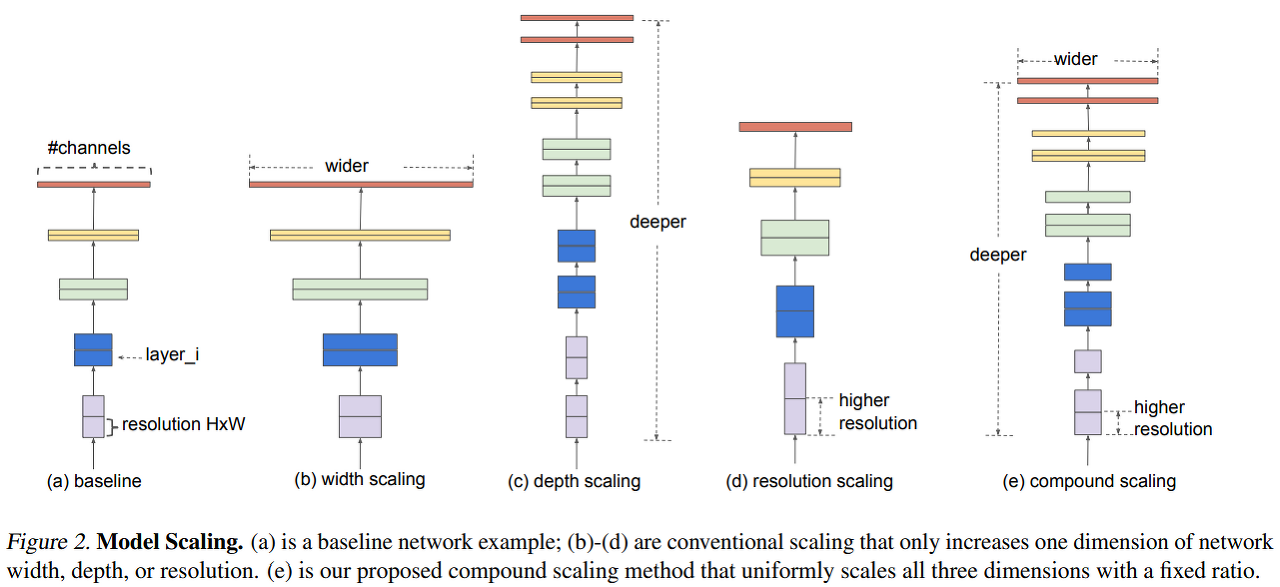

scaling을 공식화    
$$\mathcal{N} =\bigodot_{i=1...s}\mathcal{F_i}^{L_i}\left ( X_{\left \langle H_{i},W_{i}, C_{i} \right \rangle} \right)$$
* $N$ : CNN 모델
* $F_i$ : Height, Width, Channel로 구성된 Layer (Operator)
* $L_i$ : Stage i에서의 반복 수(Repeated Times in stage i)

$F_i$를 고정하고 나머지를 조절한다.
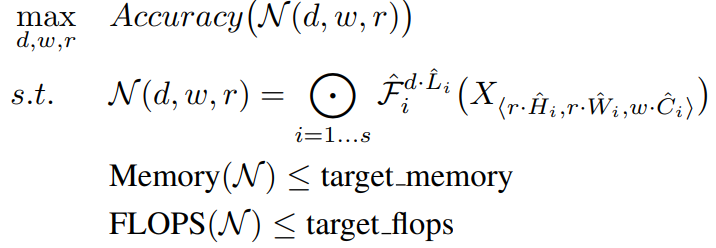

In [10]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8a5eccc113c86c80ad658776688d6e19884b0122807ccf5f866d8dbd7fc4feee
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [11]:
from efficientnet_pytorch import EfficientNet

In [13]:
efficient_pre_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 59.3MB/s]

Loaded pretrained weights for efficientnet-b0


In [16]:
efficient_pre_model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [15]:
transform_efficient = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset_efficient = dsets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                 transform=transform_efficient)

test_dataset_efficient = dsets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                transform=transform_efficient)

train_loader_efficient = torch.utils.data.DataLoader(dataset=train_dataset_efficient,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader_efficient = torch.utils.data.DataLoader(dataset=test_dataset_efficient,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficient_pre_model.parameters(), lr=learning_rate)

In [18]:
train(train_loader_efficient, efficient_pre_model, criterion, optimizer)

[Epoch:    1] Loss = 1.14260006
[Epoch:    2] Loss = 0.829455793
[Epoch:    3] Loss = 0.724063635
[Epoch:    4] Loss = 0.668184757
[Epoch:    5] Loss = 0.618703485
[Epoch:    6] Loss = 0.585068941
[Epoch:    7] Loss = 0.55736655
[Epoch:    8] Loss = 0.527234614
[Epoch:    9] Loss = 0.505812168
[Epoch:   10] Loss = 0.485348195
[Epoch:   11] Loss = 0.470902711
[Epoch:   12] Loss = 0.458782196
[Epoch:   13] Loss = 0.447658569
[Epoch:   14] Loss = 0.431616336
[Epoch:   15] Loss = 0.418666691


In [19]:
_, test_accuracy = evaluate(efficient_pre_model,test_loader_efficient)
test_accuracy

83.51